# Business Scenario

When deciding upon resourcing plans it is important to consider likely fault volumes.  Since the orders that fuel the provision work are typically taken 2 weeks in advance, a forward looking forecast of fault volumes would enable a more accurate prediction of the number of provision volumes to take on each week. 
<br>
You have been provided with the fault volume and rainfall data for a single geographic area for 3 years. Please use this data to create a model to predict the expected daily fault intake based on weather events.  Detailed explanation of the fields provided is given below.
<br>
At the interview you will be given 10 minutes to present your findings. The presentation should give an overview of your findings and be targeted at a senior stakeholder level. Please provide a copy of your findings for review before the interview. 
<br>
<br>
Things you may want to consider in the model;
<br>
1	Both short term and long term impact of rainfall
<br>
2	Impact of weather events on different fault types
<br>
3	Other things that might impact fault volume
<br>
<br>
Data provided:
<br>
Fault Data:  This contains information of individual faults for a single region over a 4 year period.
<br>
Fault ID:  Fault identifier    
<br>
Report Date: The date that the fault was reported
<br>
Initial MFL: Location of the fault;
<br>
CA: Customer appointed (home)
<br>
CE: D-side overhead network
<br>
EX: Exchange
<br>
FU: Frames (exchange)
<br>
LN: E-side Underground network
<br>
OK: Line has tested OK
<br>
OTHER: Other faults
<br>
Rainfall: This contains daily rainfall information for the same 4 year period
<br>
Observation Date: Date	
Rainfall mm: Rainfall (in mm)
<br>
Calendar Lookup: This contains a lookup to give calendar information such as day of week and bank holidays
<br>
Actual Date: Date
<br>
Day of Week: Day of Week	
Day Num Cal Week: Numeric value of day within the week	
Day Num Cal Month: Numeric value of day within the month
<br>
Day Num Cal Year: Numeric value of day within the year
<br>
Bank holiday: Flags the bank holiday (Y: bank holiday)

In [1]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import datetime
from datetime import timedelta,datetime
from sklearn import metrics

In [2]:
X = pd.read_excel('RainFallData.xlsx',index_col = 0)
Y = pd.read_excel('FaultData.xlsx', index_col = 0)

In [3]:
X['OBS_DATE'] = X.index
print(X)

                  RAINFALL_MM   OBS_DATE
OBSERVATION_DATE                        
2014-01-01               10.6 2014-01-01
2014-01-02                4.2 2014-01-02
2014-01-03                5.8 2014-01-03
2014-01-04                1.8 2014-01-04
2014-01-05               11.0 2014-01-05
2014-01-06                5.6 2014-01-06
2014-01-07                5.9 2014-01-07
2014-01-08               14.8 2014-01-08
2014-01-09                0.8 2014-01-09
2014-01-10                5.2 2014-01-10
2014-01-11                0.2 2014-01-11
2014-01-12                3.8 2014-01-12
2014-01-13                8.1 2014-01-13
2014-01-14                7.6 2014-01-14
2014-01-15                5.3 2014-01-15
2014-01-16                3.3 2014-01-16
2014-01-17                2.0 2014-01-17
2014-01-18                9.2 2014-01-18
2014-01-19                2.6 2014-01-19
2014-01-20                0.2 2014-01-20
2014-01-21                5.6 2014-01-21
2014-01-22                2.3 2014-01-22
2014-01-23      

In [4]:
# Rainfall Every 1 to 7 Days     
X['1_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-1)] for i in range(0,len(X))]
X['2_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-2)] for i in range(0,len(X))]
X['3_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-3)] for i in range(0,len(X))]
X['4_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-4)] for i in range(0,len(X))]
X['5_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-5)] for i in range(0,len(X))]
X['6_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-6)] for i in range(0,len(X))]
X['7_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-7)] for i in range(0,len(X))]

## Cummulative Rain for each week
X['Cummulative_Rain'] = [sum(X['RAINFALL_MM'][max(0,i-7):i]) for i in range(0,len(X))]
X['YMD'] = [X['OBS_DATE'][i].year*10000+X['OBS_DATE'][i].month*100+X['OBS_DATE'][i].day for i in range(0,len(X))]
X

,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,Cummulative_Rain,YMD
OBSERVATION_DATE,,,,,,,,,,,
2014-01-01,10.6,2014-01-01,10.6,10.6,10.6,10.6,10.6,10.6,10.6,0.0,20140101
2014-01-02,4.2,2014-01-02,10.6,10.6,10.6,10.6,10.6,10.6,10.6,10.6,20140102
2014-01-03,5.8,2014-01-03,4.2,10.6,10.6,10.6,10.6,10.6,10.6,14.8,20140103
2014-01-04,1.8,2014-01-04,5.8,4.2,10.6,10.6,10.6,10.6,10.6,20.6,20140104
2014-01-05,11.0,2014-01-05,1.8,5.8,4.2,10.6,10.6,10.6,10.6,22.4,20140105
2014-01-06,5.6,2014-01-06,11.0,1.8,5.8,4.2,10.6,10.6,10.6,33.4,20140106
2014-01-07,5.9,2014-01-07,5.6,11.0,1.8,5.8,4.2,10.6,10.6,39.0,20140107
2014-01-08,14.8,2014-01-08,5.9,5.6,11.0,1.8,5.8,4.2,10.6,44.9,20140108
2014-01-09,0.8,2014-01-09,14.8,5.9,5.6,11.0,1.8,5.8,4.2,49.1,20140109


In [5]:
print(type(X))
print(type(Y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Calculate Different types of Faults for 29 to 35 days

In [11]:
Y.head()
(Y['REPORT_DATE'][0]).day

1

In [12]:
Y['YMD'] = [Y['REPORT_DATE'][i].year*10000+Y['REPORT_DATE'][i].month*100+Y['REPORT_DATE'][i].day for i in range(0,len(Y))]
Y.head()

,REPORT_DATE,INITIAL_MFL,YMD,COUNT
Fault ID,,,,
ID000001,2014-01-01,CE,20140101,1
ID000002,2014-01-01,CA,20140101,1
ID000003,2014-01-01,OTHER,20140101,1
ID000004,2014-01-01,OK,20140101,1
ID000005,2014-01-01,LN,20140101,1


In [13]:
Y['COUNT'] = 1
Z = pd.pivot_table(Y,values=['COUNT'],index='YMD',columns='INITIAL_MFL',aggfunc=sum).reset_index()

In [14]:
Z.columns=['YMD','FAULTS_CA','FAULTS_CE','FAULTS_EX','FAULTS_FU','FAULTS_LN','FAULTS_OK','FAULTS_OTHER']
Z.head()

,YMD,FAULTS_CA,FAULTS_CE,FAULTS_EX,FAULTS_FU,FAULTS_LN,FAULTS_OK,FAULTS_OTHER
0,20140101,15.0,40.0,6.0,4.0,38.0,26.0,17.0
1,20140102,47.0,100.0,3.0,13.0,67.0,83.0,24.0
2,20140103,63.0,87.0,6.0,14.0,77.0,79.0,28.0
3,20140104,24.0,60.0,3.0,6.0,34.0,47.0,8.0
4,20140105,16.0,28.0,2.0,4.0,31.0,41.0,9.0


In [15]:
for fault in Z.columns[1:]:
    newfault = fault.replace('FAULTS_','29to35Faults_')    
    Z[fault]=Z[fault].fillna(0).replace(np.nan,0)
    Z[newfault]=[sum(Z[fault][min(i+29,len(Z)):min(i+35,len(Z))]) for i in range(0,len(Z))]

In [16]:
Z.tail(50)

,YMD,FAULTS_CA,FAULTS_CE,FAULTS_EX,FAULTS_FU,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,29to35Faults_CA,29to35Faults_CE,29to35Faults_EX,29to35Faults_FU,29to35Faults_LN,29to35Faults_OK,29to35Faults_OTHER
1136,20170210,13.0,89.0,0.0,12.0,37.0,76.0,5.0,157.0,461.0,13.0,70.0,196.0,520.0,71.0
1137,20170211,16.0,56.0,0.0,6.0,27.0,47.0,5.0,166.0,476.0,13.0,82.0,220.0,544.0,82.0
1138,20170212,15.0,40.0,1.0,3.0,10.0,46.0,3.0,170.0,500.0,12.0,85.0,226.0,534.0,86.0
1139,20170213,29.0,84.0,6.0,14.0,36.0,81.0,10.0,161.0,466.0,9.0,89.0,209.0,468.0,76.0
1140,20170214,20.0,85.0,2.0,10.0,34.0,75.0,15.0,175.0,489.0,5.0,83.0,217.0,506.0,80.0
1141,20170215,26.0,101.0,3.0,13.0,33.0,108.0,12.0,160.0,486.0,8.0,81.0,237.0,499.0,85.0
1142,20170216,25.0,77.0,2.0,10.0,25.0,80.0,7.0,148.0,486.0,8.0,80.0,230.0,476.0,69.0
1143,20170217,21.0,66.0,1.0,17.0,27.0,72.0,8.0,149.0,518.0,8.0,75.0,232.0,475.0,67.0
1144,20170218,10.0,57.0,0.0,13.0,24.0,51.0,6.0,165.0,557.0,10.0,74.0,248.0,522.0,71.0
1145,20170219,12.0,39.0,9.0,3.0,3.0,46.0,3.0,163.0,560.0,10.0,70.0,248.0,535.0,71.0


In [17]:
## Merge DataFrame
df=X.merge(Z,on='YMD')
df = df[7:len(df)-35]
df = df.reset_index()
df

,index,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,...,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,29to35Faults_CA,29to35Faults_CE,29to35Faults_EX,29to35Faults_FU,29to35Faults_LN,29to35Faults_OK,29to35Faults_OTHER
0,7,14.8,2014-01-08,5.9,5.6,11.0,1.8,5.8,4.2,10.6,...,61.0,93.0,68.0,211.0,469.0,24.0,61.0,246.0,394.0,92.0
1,8,0.8,2014-01-09,14.8,5.9,5.6,11.0,1.8,5.8,4.2,...,54.0,92.0,26.0,199.0,556.0,24.0,67.0,265.0,393.0,105.0
2,9,5.2,2014-01-10,0.8,14.8,5.9,5.6,11.0,1.8,5.8,...,65.0,69.0,15.0,227.0,897.0,30.0,78.0,395.0,414.0,200.0
3,10,0.2,2014-01-11,5.2,0.8,14.8,5.9,5.6,11.0,1.8,...,22.0,45.0,11.0,240.0,1036.0,56.0,85.0,549.0,426.0,247.0
4,11,3.8,2014-01-12,0.2,5.2,0.8,14.8,5.9,5.6,11.0,...,27.0,38.0,9.0,256.0,1094.0,63.0,88.0,625.0,430.0,260.0
5,12,8.1,2014-01-13,3.8,0.2,5.2,0.8,14.8,5.9,5.6,...,82.0,71.0,16.0,244.0,1071.0,62.0,80.0,619.0,377.0,236.0
6,13,7.6,2014-01-14,8.1,3.8,0.2,5.2,0.8,14.8,5.9,...,63.0,93.0,41.0,265.0,1154.0,73.0,84.0,702.0,424.0,259.0
7,14,5.3,2014-01-15,7.6,8.1,3.8,0.2,5.2,0.8,14.8,...,65.0,87.0,21.0,262.0,1115.0,76.0,89.0,701.0,436.0,253.0
8,15,3.3,2014-01-16,5.3,7.6,8.1,3.8,0.2,5.2,0.8,...,48.0,71.0,17.0,227.0,814.0,73.0,80.0,591.0,404.0,175.0
9,16,2.0,2014-01-17,3.3,5.3,7.6,8.1,3.8,0.2,5.2,...,59.0,55.0,13.0,215.0,737.0,48.0,77.0,485.0,402.0,132.0


In [18]:
train, test = train_test_split(df, test_size=0.2)

In [19]:
train.head()

,index,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,...,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,29to35Faults_CA,29to35Faults_CE,29to35Faults_EX,29to35Faults_FU,29to35Faults_LN,29to35Faults_OK,29to35Faults_OTHER
180,187,1.7,2014-07-07,2.7,0.1,15.3,1.5,0.3,0.0,0.0,...,36.0,80.0,24.0,108.0,289.0,16.0,68.0,116.0,477.0,91.0
208,215,0.0,2014-08-04,0.6,8.4,13.5,2.3,0.0,0.3,0.2,...,46.0,126.0,23.0,104.0,295.0,35.0,73.0,126.0,353.0,50.0
165,172,0.0,2014-06-22,0.0,0.0,0.0,0.0,0.0,0.0,0.6,...,8.0,40.0,4.0,152.0,419.0,86.0,76.0,204.0,422.0,80.0
130,137,1.1,2014-05-18,0.0,0.0,0.0,0.0,0.6,2.8,6.9,...,13.0,34.0,6.0,156.0,422.0,36.0,90.0,176.0,447.0,74.0
989,996,0.6,2016-09-22,3.7,0.0,0.0,3.9,0.0,0.1,0.2,...,51.0,95.0,10.0,118.0,341.0,19.0,59.0,181.0,440.0,52.0


In [20]:
test.head()

,index,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,...,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,29to35Faults_CA,29to35Faults_CE,29to35Faults_EX,29to35Faults_FU,29to35Faults_LN,29to35Faults_OK,29to35Faults_OTHER
1117,1124,6.2,2017-01-28,5.6,0.0,0.0,0.5,0.2,0.6,0.1,...,26.0,61.0,8.0,189.0,625.0,10.0,87.0,280.0,478.0,73.0
890,897,9.5,2016-06-15,12.3,6.8,3.5,4.4,6.3,2.8,2.0,...,52.0,105.0,14.0,157.0,331.0,30.0,58.0,181.0,403.0,77.0
142,149,0.0,2014-05-30,0.3,1.4,1.2,0.4,2.9,6.7,10.9,...,16.0,64.0,20.0,116.0,387.0,13.0,80.0,151.0,404.0,79.0
899,906,0.9,2016-06-24,0.2,0.4,0.7,3.8,14.4,0.0,0.3,...,40.0,77.0,12.0,270.0,411.0,17.0,74.0,267.0,451.0,63.0
905,912,7.3,2016-06-30,14.0,9.3,0.1,6.0,1.4,0.9,0.2,...,39.0,62.0,10.0,207.0,336.0,16.0,78.0,226.0,514.0,57.0


# CA - FAULT MODELS

## Linear Regression

In [24]:
# Split Train Test Data for CA Faults
df_ca = df[['Cummulative_Rain','29to35Faults_CA']]
df_ca_train, df_ca_test = train_test_split(df_ca, test_size=0.2,random_state=1801)

In [192]:
df_ca.corr()

,Cummulative_Rain,29to35Faults_CA
Cummulative_Rain,1.000000,0.219337
29to35Faults_CA,0.219337,1.000000


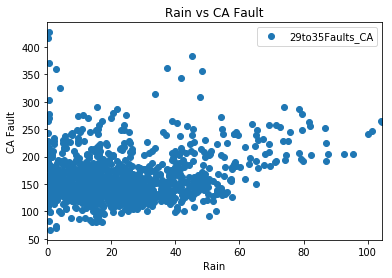

In [25]:
df_ca.plot(x='Cummulative_Rain', y='29to35Faults_CA', style='o')  
plt.title('Rain vs CA Fault')  
plt.xlabel('Rain')  
plt.ylabel('CA Fault')  
plt.show()

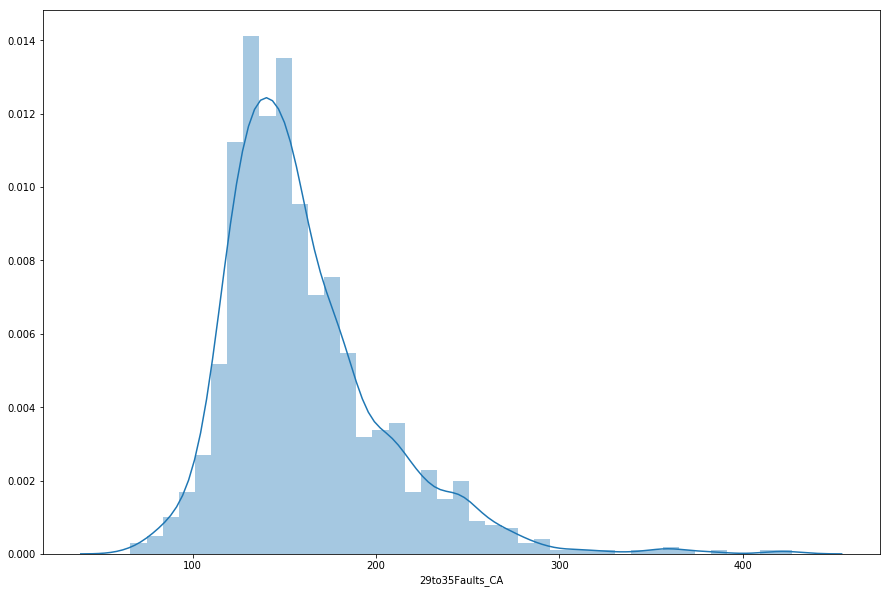

In [26]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ca['29to35Faults_CA'])

In [27]:
# Find TRAIN Set Data for 15 to 21 Days for CA Faults
df_ca_train_np_rain=df_ca_train['Cummulative_Rain'].to_numpy()
df_ca_train_np_fault = df_ca_train['29to35Faults_CA'].to_numpy()

# Reshape test train data
df_ca_train_rain = df_ca_train_np_rain.reshape(len(df_ca_train_np_rain),1)
df_ca_train_fault = df_ca_train_np_fault.reshape(len(df_ca_train_np_fault),1)

In [28]:
lr = LinearRegression().fit(df_ca_train_rain,df_ca_train_fault)

In [29]:
print(lr.coef_)
print(lr.intercept_)

[[0.47427518]]
[149.49912682]


In [30]:
# Find TEST Set Data for 15 to 21 Days for CA Faults
df_ca_test_np_rain=df_ca_test['Cummulative_Rain'].to_numpy()
df_ca_test_np_fault = df_ca_test['29to35Faults_CA'].to_numpy()

df_ca_test_rain = df_ca_test_np_rain.reshape(len(df_ca_test_np_rain),1)
df_ca_test_fault = df_ca_test_np_fault.reshape(len(df_ca_test_np_fault),1)

In [31]:
# Train Model Accuracy
lr.score(df_ca_train_rain, df_ca_train_fault)

0.03919502676997954

In [32]:
# testing model accuracy in test set
lr.score(df_ca_test_rain, df_ca_test_fault)

0.08537420789524908

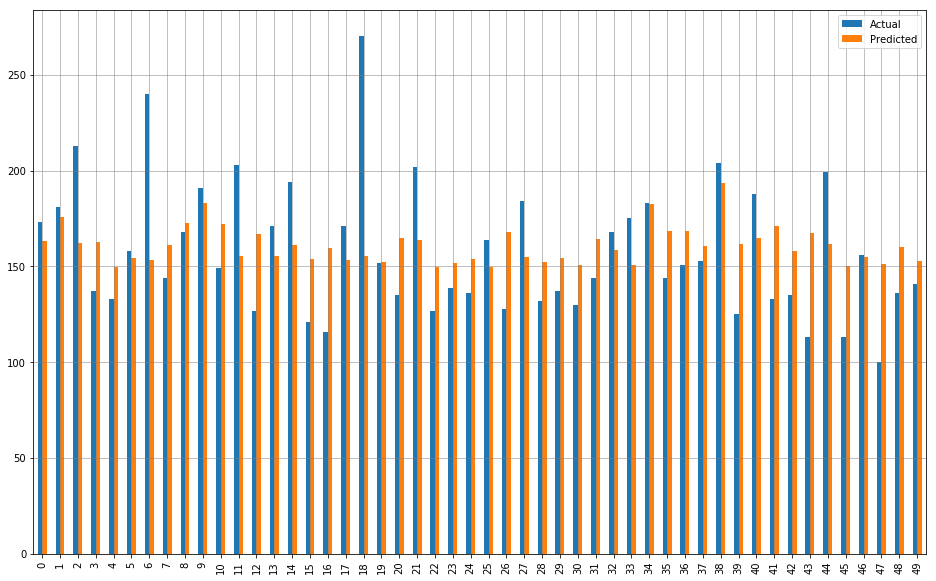

In [33]:
predict_linear = lr.predict(df_ca_test_rain)
actual_pred_linear= pd.DataFrame({'Actual': df_ca_test_fault.flatten(), 'Predicted': predict_linear.flatten()})
bar_plot_df = actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

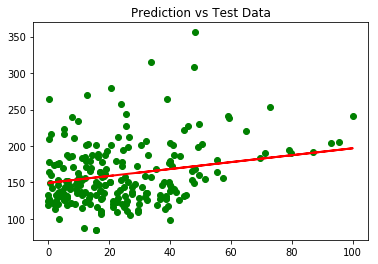

In [34]:
plt.scatter(df_ca_test_rain, df_ca_test_fault,  color='green')
plt.plot(df_ca_test_rain, predict_linear, color='red', linewidth=2)
plt.title('Prediction vs Test Data') 
plt.show()

In [35]:
rmspe = (np.sqrt(np.mean(np.square((df_ca_test_fault - predict_linear) / df_ca_test_fault)))) * 100
print('Root Mean Squared Error Percentage for CA Faults: ', rmspe,'%')

Root Mean Squared Error Percentage for CA Faults:  24.497530838319857 %


# OK FAULT MODELS

In [36]:
df_ok = df[['Cummulative_Rain','29to35Faults_OK']]
df_ok_train, df_ok_test = train_test_split(df_ok, test_size=0.2,random_state=1801)

In [193]:
df_ok.corr()

,Cummulative_Rain,29to35Faults_OK
Cummulative_Rain,1.000000,0.047124
29to35Faults_OK,0.047124,1.000000


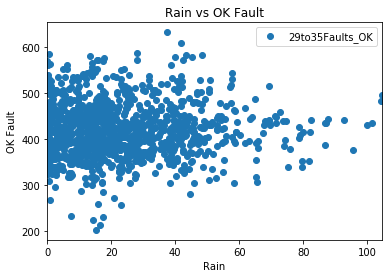

In [37]:
df_ok.plot(x='Cummulative_Rain', y='29to35Faults_OK', style='o')  
plt.title('Rain vs OK Fault')  
plt.xlabel('Rain')  
plt.ylabel('OK Fault')  
plt.show()

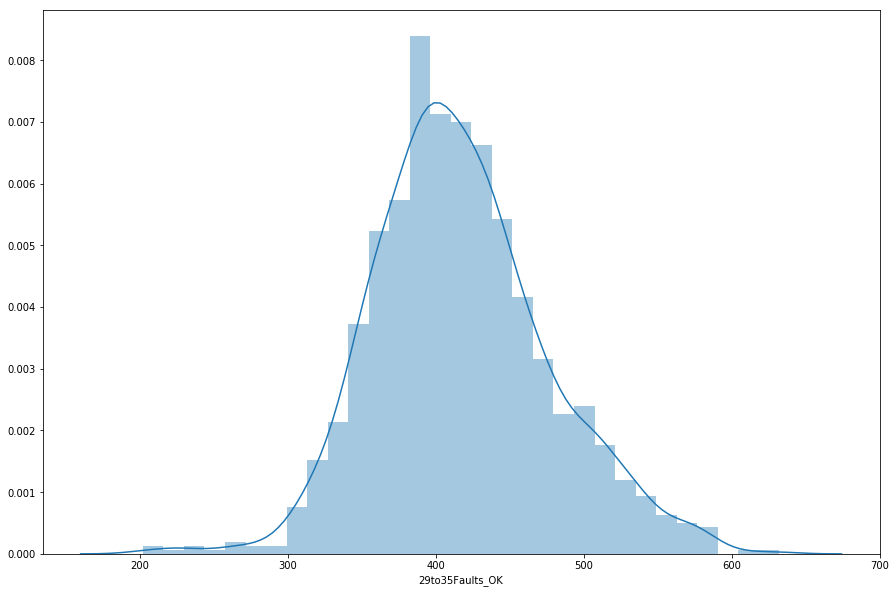

In [38]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ok['29to35Faults_OK'])

In [39]:
# Find TRAIN Set Data for 15 to 21 Days for OK Faults
df_ok_train_np_rain=df_ok_train['Cummulative_Rain'].to_numpy()
df_ok_train_np_fault = df_ok_train['29to35Faults_OK'].to_numpy()

# Reshape test train data
df_ok_train_rain = df_ok_train_np_rain.reshape(len(df_ok_train_np_rain),1)
df_ok_train_fault = df_ok_train_np_fault.reshape(len(df_ok_train_np_fault),1)

In [40]:
lr = LinearRegression().fit(df_ok_train_rain,df_ok_train_fault)

In [41]:
# Train Model Accuracy
lr.score(df_ok_train_rain, df_ok_train_fault)

0.0008892046714681355

In [42]:
# Find TEST Set Data for 15 to 21 Days for OK Faults
df_ok_test_np_rain=df_ok_test['Cummulative_Rain'].to_numpy()
df_ok_test_np_fault = df_ok_test['29to35Faults_OK'].to_numpy()

df_ok_test_rain = df_ok_test_np_rain.reshape(len(df_ok_test_np_rain),1)
df_ok_test_fault = df_ok_test_np_fault.reshape(len(df_ok_test_np_fault),1)

In [43]:
# testing model accuracy in test set
lr.score(df_ok_test_rain, df_ok_test_fault)

0.003698449911566648

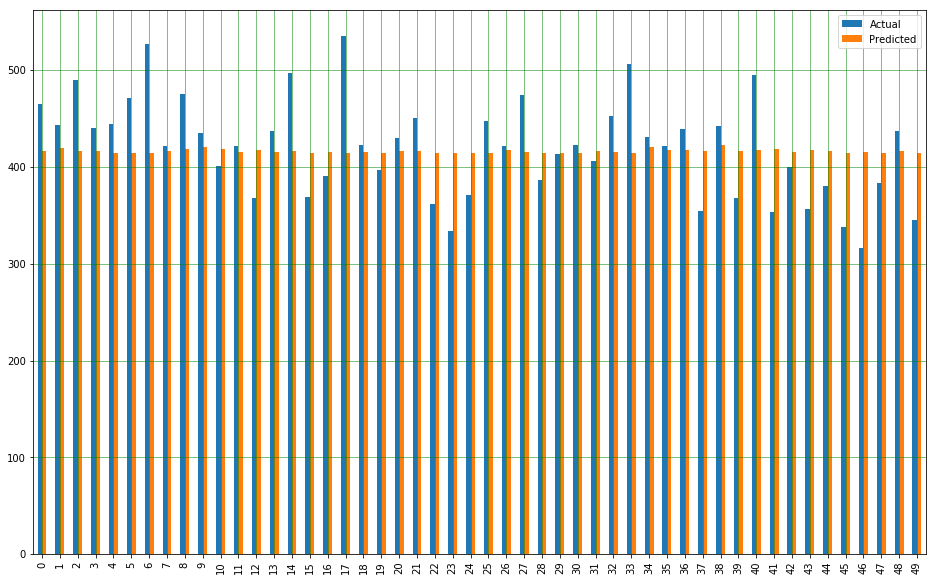

In [44]:
pred_OK_Fault_linear = lr.predict(df_ok_test_rain)
OK_actual_pred_linear= pd.DataFrame({'Actual': df_ok_test_fault.flatten(), 'Predicted': pred_OK_Fault_linear.flatten()})
bar_plot_df = OK_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

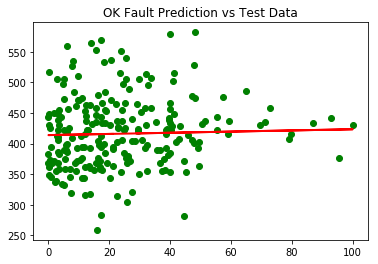

In [45]:
plt.scatter(df_ok_test_rain, df_ok_test_fault,  color='green')
plt.plot(df_ca_test_rain, pred_OK_Fault_linear, color='red', linewidth=2)
plt.title('OK Fault Prediction vs Test Data') 
plt.show()

In [46]:
rmspe_ok = (np.sqrt(np.mean(np.square((df_ok_test_fault - pred_OK_Fault_linear) / df_ok_test_fault)))) * 100
print('Root Mean Squared Error Percentage for OK Faults: ', rmspe_ok,'%')

Root Mean Squared Error Percentage for OK Faults:  14.240701528516144 %


# CE FAULT MODEL

## Linear Regression on Faults CE

In [47]:
df_ce = df[['Cummulative_Rain','29to35Faults_CE']]
df_ce_train, df_ce_test = train_test_split(df_ce, test_size=0.2,random_state=1801)

In [194]:
df_ce.corr()

,Cummulative_Rain,29to35Faults_CE
Cummulative_Rain,1.000000,0.221661
29to35Faults_CE,0.221661,1.000000


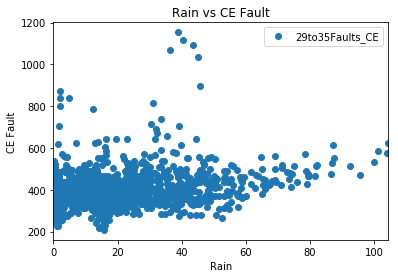

In [48]:
df_ce.plot(x='Cummulative_Rain', y='29to35Faults_CE', style='o')  
plt.title('Rain vs CE Fault')  
plt.xlabel('Rain')  
plt.ylabel('CE Fault')  
plt.show()

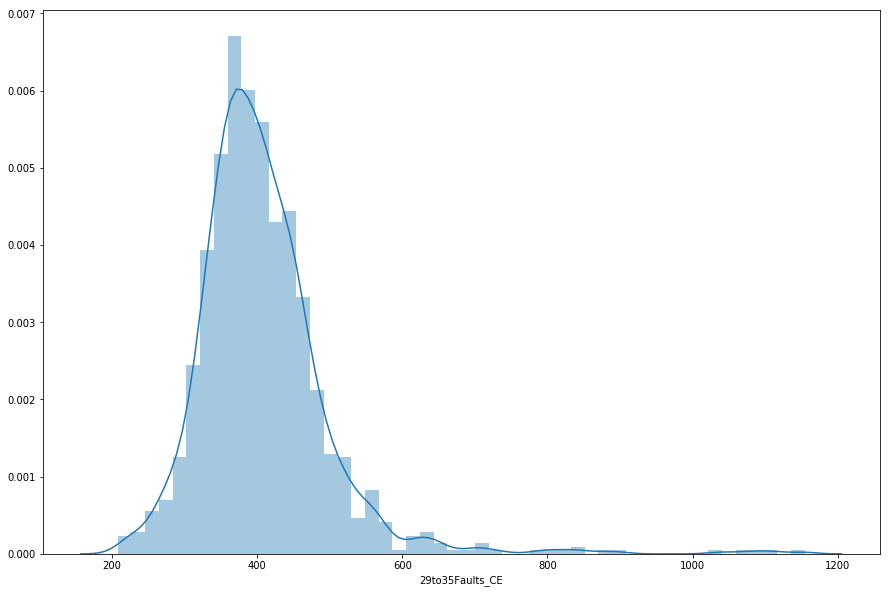

In [49]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ce['29to35Faults_CE'])

In [50]:
# Find TRAIN Set Data for 15 to 21 Days for CA Faults
df_ce_train_np_rain=df_ce_train['Cummulative_Rain'].to_numpy()
df_ce_train_np_fault = df_ce_train['29to35Faults_CE'].to_numpy()

# Reshape test train data
df_ce_train_rain = df_ce_train_np_rain.reshape(len(df_ce_train_np_rain),1)
df_ce_train_fault = df_ce_train_np_fault.reshape(len(df_ce_train_np_fault),1)

In [51]:
lr = LinearRegression().fit(df_ce_train_rain,df_ce_train_fault)

In [52]:
lr.score(df_ce_train_rain, df_ce_train_fault)

0.04029796464960034

In [53]:
# Find TEST Set Data for 15 to 21 Days for CA Faults
df_ce_test_np_rain=df_ce_test['Cummulative_Rain'].to_numpy()
df_ce_test_np_fault = df_ce_test['29to35Faults_CE'].to_numpy()

df_ce_test_rain = df_ce_test_np_rain.reshape(len(df_ce_test_np_rain),1)
df_ce_test_fault = df_ce_test_np_fault.reshape(len(df_ce_test_np_fault),1)

In [54]:
# testing model accuracy in test set
lr.score(df_ce_test_rain, df_ce_test_fault)

0.08133819075504167

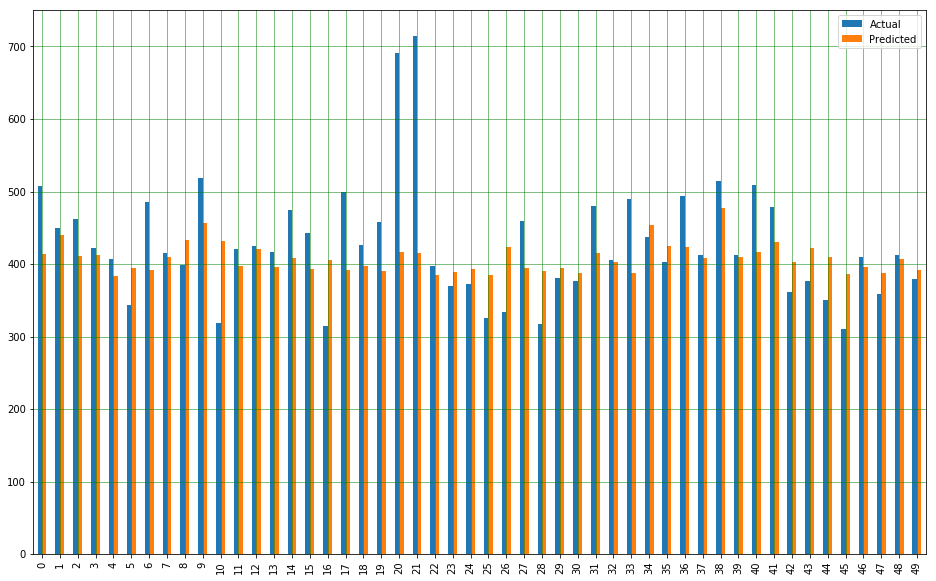

In [55]:
pred_ce_Fault_linear = lr.predict(df_ce_test_rain)
ce_actual_pred_linear= pd.DataFrame({'Actual': df_ce_test_fault.flatten(), 'Predicted': pred_ce_Fault_linear.flatten()})
bar_plot_df = ce_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

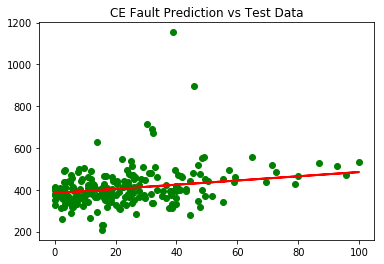

In [56]:
plt.scatter(df_ce_test_rain, df_ce_test_fault,  color='green')
plt.plot(df_ce_test_rain, pred_ce_Fault_linear, color='red', linewidth=2)
plt.title('CE Fault Prediction vs Test Data') 
plt.show()

In [57]:
rmspe_ce = (np.sqrt(np.mean(np.square((df_ce_test_fault - pred_ce_Fault_linear) / df_ce_test_fault)))) * 100
print('Root Mean Squared Error Percentage for CE Faults: ', rmspe_ok,'%')

Root Mean Squared Error Percentage for CE Faults:  14.240701528516144 %


# EX FAULT MODEL

## Linear Regression

In [58]:
df_ex = df[['Cummulative_Rain','29to35Faults_EX']]
df_ex_train, df_ex_test = train_test_split(df_ex, test_size=0.2,random_state=1801)

In [195]:
df_ex.corr()

,Cummulative_Rain,29to35Faults_EX
Cummulative_Rain,1.000000,-0.127833
29to35Faults_EX,-0.127833,1.000000


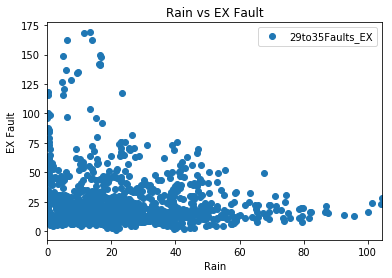

In [59]:
df_ex.plot(x='Cummulative_Rain', y='29to35Faults_EX', style='o')  
plt.title('Rain vs EX Fault')  
plt.xlabel('Rain')  
plt.ylabel('EX Fault')  
plt.show()

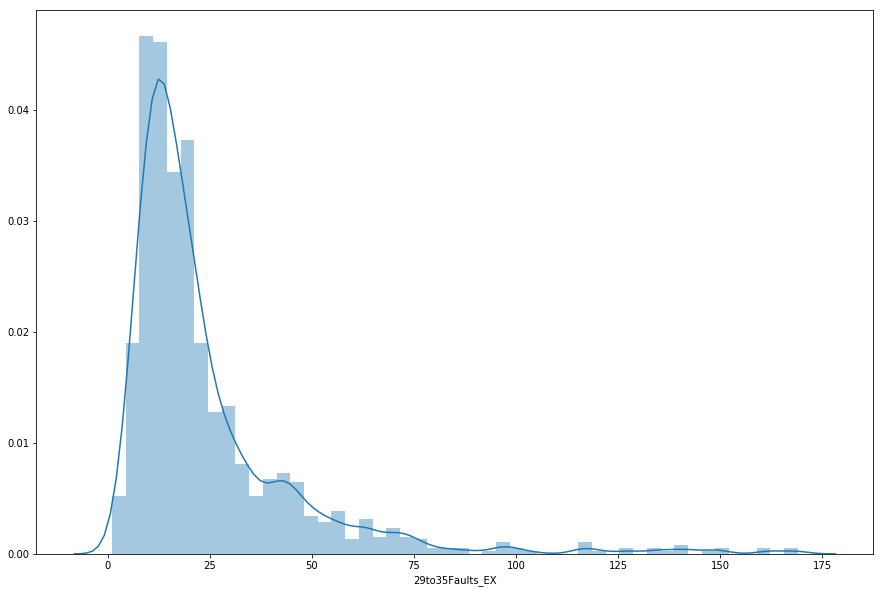

In [60]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ex['29to35Faults_EX'])

In [61]:
# Find TRAIN Set Data for 15 to 21 Days for CA Faults
df_ex_train_np_rain=df_ex_train['Cummulative_Rain'].to_numpy()
df_ex_train_np_fault = df_ex_train['29to35Faults_EX'].to_numpy()

# Reshape test train data
df_ex_train_rain = df_ex_train_np_rain.reshape(len(df_ex_train_np_rain),1)
df_ex_train_fault = df_ex_train_np_fault.reshape(len(df_ex_train_np_fault),1)

In [62]:
lr = LinearRegression().fit(df_ex_train_rain,df_ex_train_fault)

In [63]:
lr.score(df_ex_train_rain, df_ex_train_fault)

0.013885844860986651

In [64]:
# Find TEST Set Data for 15 to 21 Days for CA Faults
df_ex_test_np_rain=df_ex_test['Cummulative_Rain'].to_numpy()
df_ex_test_np_fault = df_ex_test['29to35Faults_EX'].to_numpy()

df_ex_test_rain = df_ex_test_np_rain.reshape(len(df_ex_test_np_rain),1)
df_ex_test_fault = df_ex_test_np_fault.reshape(len(df_ex_test_np_fault),1)

In [65]:
# testing model accuracy in test set
lr.score(df_ex_test_rain, df_ex_test_fault)

0.024408000281454508

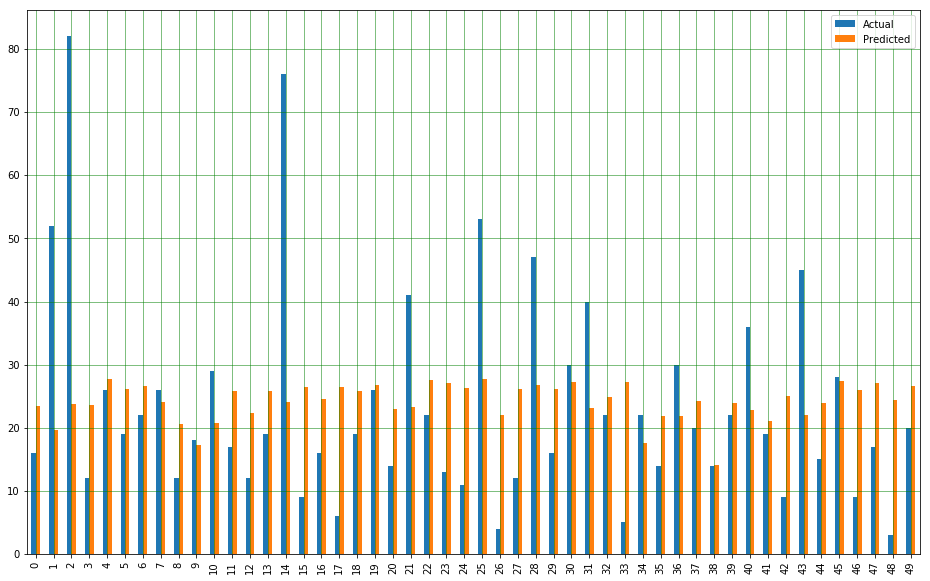

In [66]:
pred_ex_Fault_linear = lr.predict(df_ex_test_rain)
ex_actual_pred_linear= pd.DataFrame({'Actual': df_ex_test_fault.flatten(), 'Predicted': pred_ex_Fault_linear.flatten()})
bar_plot_df = ex_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

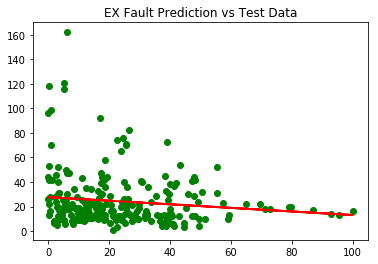

In [67]:
plt.scatter(df_ex_test_rain, df_ex_test_fault,  color='green')
plt.plot(df_ex_test_rain, pred_ex_Fault_linear, color='red', linewidth=2)
plt.title('EX Fault Prediction vs Test Data') 
plt.show()

In [68]:
rmspe_ex = (np.sqrt(np.mean(np.square((df_ex_test_fault - pred_ex_Fault_linear) / df_ex_test_fault)))) * 100
print('Root Mean Squared Error Percentage for EX Faults: ', rmspe_ex,'%')

Root Mean Squared Error Percentage for EX Faults:  204.0241828291109 %


# FU FAULT MODEL

## Linear Regression

In [69]:
df_fu = df[['Cummulative_Rain','29to35Faults_FU']]
df_fu_train, df_fu_test = train_test_split(df_fu, test_size=0.2,random_state=1801)

In [196]:
df_fu.corr()

,Cummulative_Rain,29to35Faults_FU
Cummulative_Rain,1.000000,0.200868
29to35Faults_FU,0.200868,1.000000


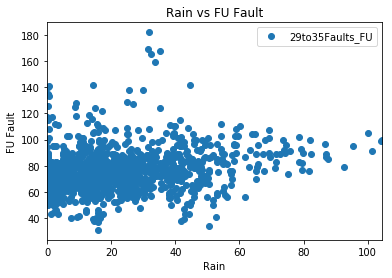

In [70]:
df_fu.plot(x='Cummulative_Rain', y='29to35Faults_FU', style='o')  
plt.title('Rain vs FU Fault')  
plt.xlabel('Rain')  
plt.ylabel('FU Fault')  
plt.show()

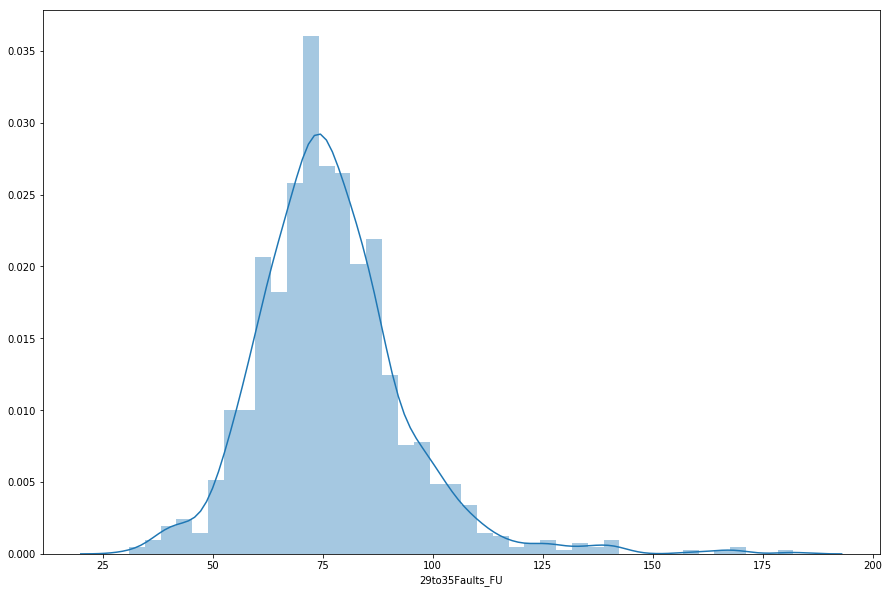

In [71]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_fu['29to35Faults_FU'])

In [72]:
# Find TRAIN Set Data for 15 to 21 Days for FU Faults
df_fu_train_np_rain=df_fu_train['Cummulative_Rain'].to_numpy()
df_fu_train_np_fault = df_fu_train['29to35Faults_FU'].to_numpy()

# Reshape test train data
df_fu_train_rain = df_fu_train_np_rain.reshape(len(df_fu_train_np_rain),1)
df_fu_train_fault = df_fu_train_np_fault.reshape(len(df_fu_train_np_fault),1)

In [73]:
lr = LinearRegression().fit(df_fu_train_rain,df_fu_train_fault)

In [74]:
lr.score(df_fu_train_rain, df_fu_train_fault)

0.03326805035947833

In [75]:
# Find TEST Set Data for 15 to 21 Days for FU Faults
df_fu_test_np_rain=df_fu_test['Cummulative_Rain'].to_numpy()
df_fu_test_np_fault = df_fu_test['29to35Faults_FU'].to_numpy()

df_fu_test_rain = df_fu_test_np_rain.reshape(len(df_fu_test_np_rain),1)
df_fu_test_fault = df_fu_test_np_fault.reshape(len(df_fu_test_np_fault),1)

In [76]:
# testing model accuracy in test set
lr.score(df_fu_test_rain, df_fu_test_fault)

0.06734071491453497

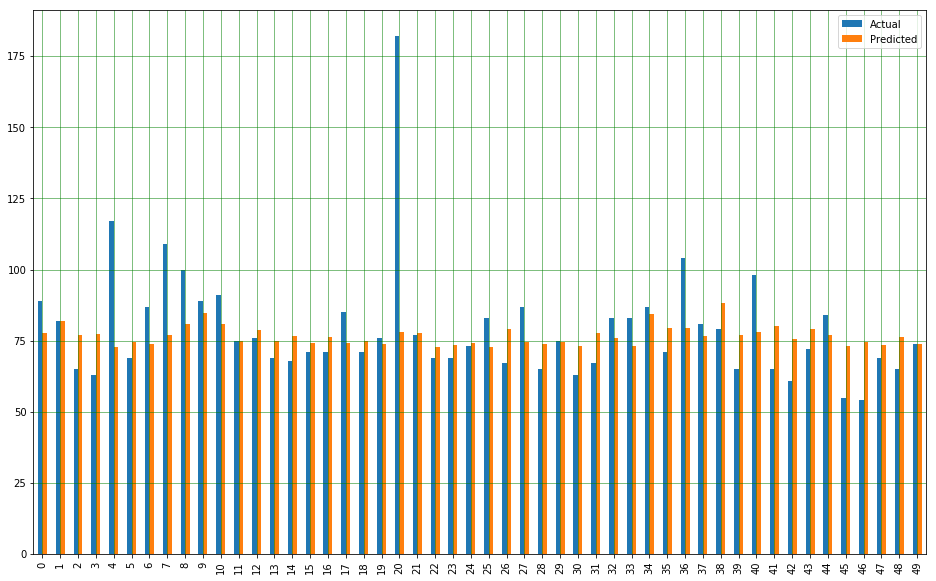

In [77]:
pred_fu_Fault_linear = lr.predict(df_fu_test_rain)
fu_actual_pred_linear= pd.DataFrame({'Actual': df_fu_test_fault.flatten(), 'Predicted': pred_fu_Fault_linear.flatten()})
bar_plot_df = fu_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

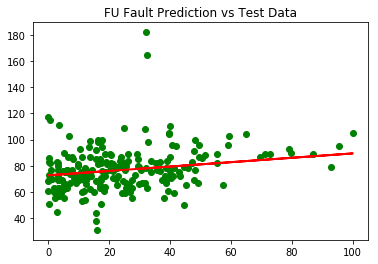

In [78]:
plt.scatter(df_fu_test_rain, df_fu_test_fault,  color='green')
plt.plot(df_fu_test_rain, pred_fu_Fault_linear, color='red', linewidth=2)
plt.title('FU Fault Prediction vs Test Data') 
plt.show()

In [79]:
rmspe_fu = (np.sqrt(np.mean(np.square((df_fu_test_fault - pred_fu_Fault_linear) / df_fu_test_fault)))) * 100
print('Root Mean Squared Error Percentage for FU Faults: ', rmspe_fu,'%')

Root Mean Squared Error Percentage for FU Faults:  21.560791690113394 %


# LN FAULT MODEL

## Linear Regression

In [80]:
df_ln = df[['Cummulative_Rain','29to35Faults_LN']]
df_ln_train, df_ln_test = train_test_split(df_ln, test_size=0.2,random_state=1801)

In [197]:
df_ln.corr()

,Cummulative_Rain,29to35Faults_LN
Cummulative_Rain,1.000000,0.302813
29to35Faults_LN,0.302813,1.000000


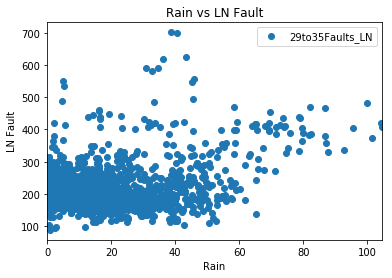

In [81]:
df_ln.plot(x='Cummulative_Rain', y='29to35Faults_LN', style='o')  
plt.title('Rain vs LN Fault')  
plt.xlabel('Rain')  
plt.ylabel('LN Fault')  
plt.show()

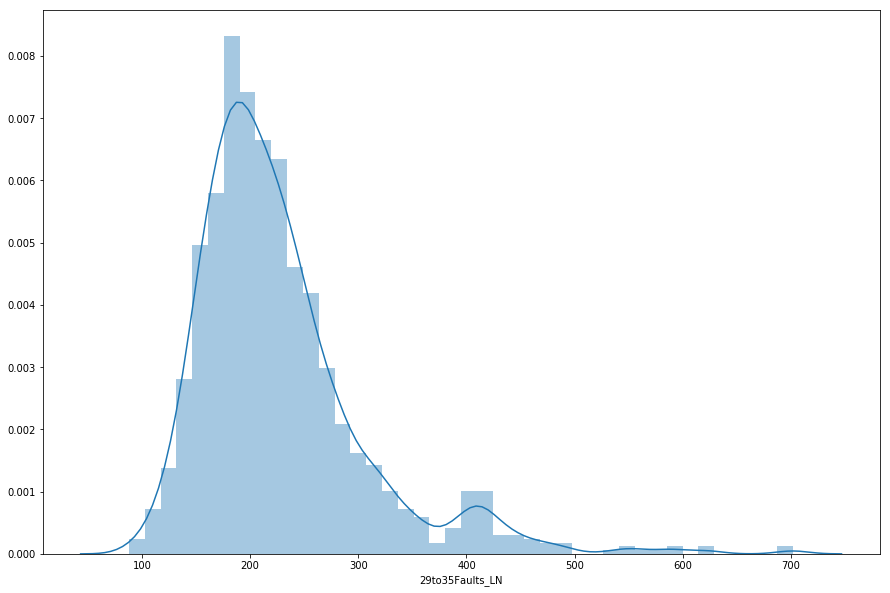

In [82]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ln['29to35Faults_LN'])

In [83]:
# Find TRAIN Set Data for 15 to 21 Days for LN Faults
df_ln_train_np_rain=df_ln_train['Cummulative_Rain'].to_numpy()
df_ln_train_np_fault = df_ln_train['29to35Faults_LN'].to_numpy()

# Reshape test train data
df_ln_train_rain = df_ln_train_np_rain.reshape(len(df_ln_train_np_rain),1)
df_ln_train_fault = df_ln_train_np_fault.reshape(len(df_ln_train_np_fault),1)

In [84]:
lr = LinearRegression().fit(df_ln_train_rain,df_ln_train_fault)

In [85]:
lr.score(df_ln_train_rain, df_ln_train_fault)

0.06895246941319677

In [86]:
# Find TEST Set Data for 15 to 21 Days for FU Faults
df_ln_test_np_rain=df_ln_test['Cummulative_Rain'].to_numpy()
df_ln_test_np_fault = df_ln_test['29to35Faults_LN'].to_numpy()

df_ln_test_rain = df_ln_test_np_rain.reshape(len(df_ln_test_np_rain),1)
df_ln_test_fault = df_ln_test_np_fault.reshape(len(df_ln_test_np_fault),1)

In [87]:
# testing model accuracy in test set
lr.score(df_ln_test_rain, df_ln_test_fault)

0.16658790305590654

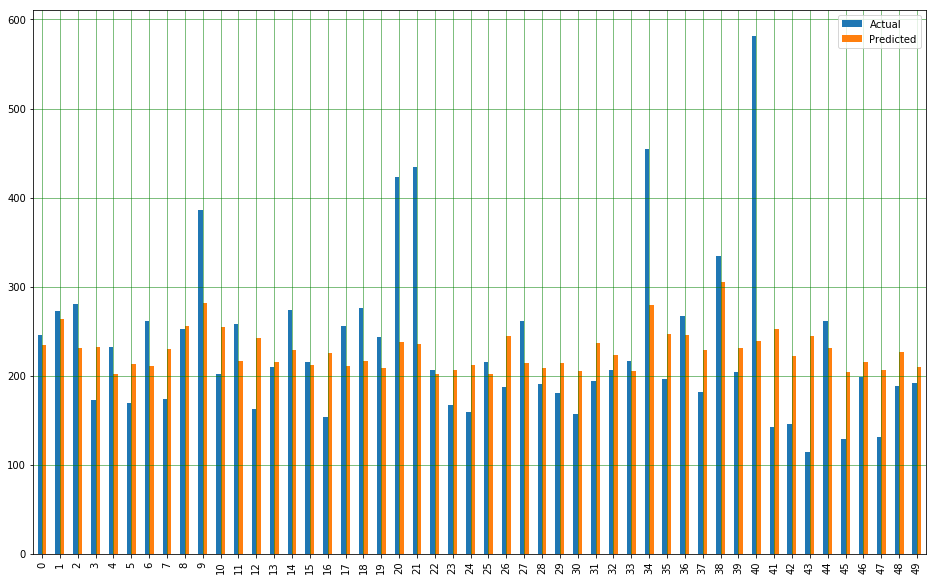

In [88]:
pred_ln_Fault_linear = lr.predict(df_ln_test_rain)
ln_actual_pred_linear= pd.DataFrame({'Actual': df_ln_test_fault.flatten(), 'Predicted': pred_ln_Fault_linear.flatten()})
bar_plot_df = ln_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

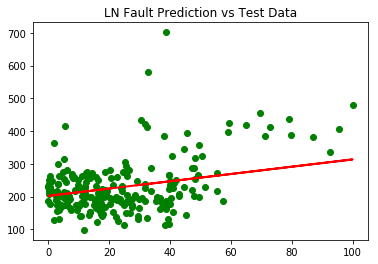

In [89]:
plt.scatter(df_ln_test_rain, df_ln_test_fault,  color='green')
plt.plot(df_ln_test_rain, pred_ln_Fault_linear, color='red', linewidth=2)
plt.title('LN Fault Prediction vs Test Data') 
plt.show()

In [90]:
rmspe_ln = (np.sqrt(np.mean(np.square((df_ln_test_fault - pred_ln_Fault_linear) / df_ln_test_fault)))) * 100
print('Root Mean Squared Error Percentage for LN Faults: ', rmspe_ln,'%')

Root Mean Squared Error Percentage for LN Faults:  32.71374764995076 %


# OTHER FAULT MODEL

## Linear Regression

In [91]:
df_other = df[['Cummulative_Rain','29to35Faults_OTHER']]
df_other_train, df_other_test = train_test_split(df_other, test_size=0.2,random_state=1801)

In [198]:
df_other.corr()

,Cummulative_Rain,29to35Faults_OTHER
Cummulative_Rain,1.000000,0.075699
29to35Faults_OTHER,0.075699,1.000000


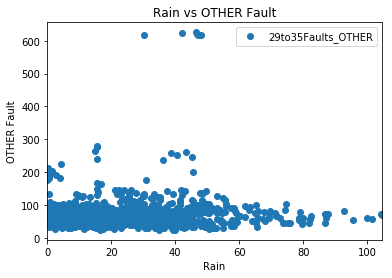

In [92]:
df_other.plot(x='Cummulative_Rain', y='29to35Faults_OTHER', style='o')  
plt.title('Rain vs OTHER Fault')  
plt.xlabel('Rain')  
plt.ylabel('OTHER Fault')  
plt.show()

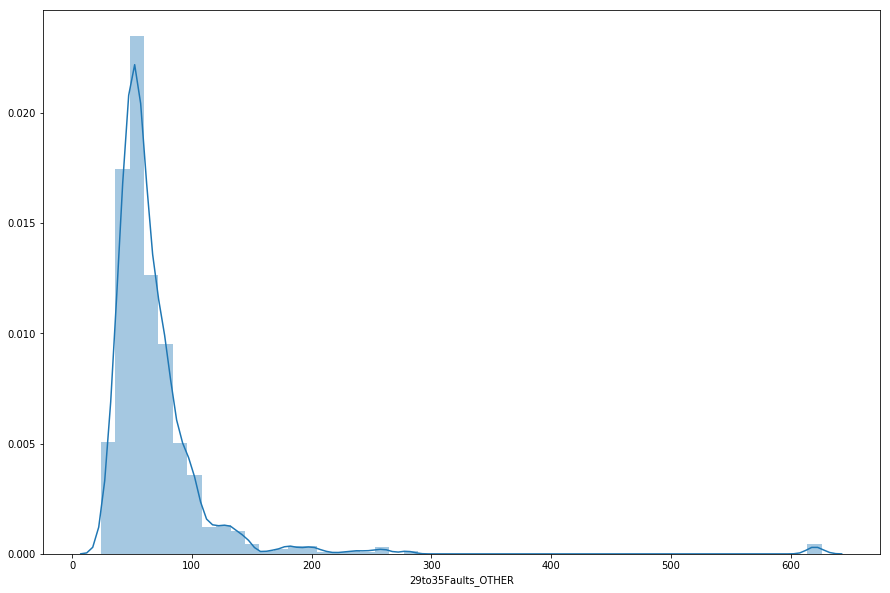

In [93]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_other['29to35Faults_OTHER'])

In [94]:
# Find TRAIN Set Data for 15 to 21 Days for OTHER Faults
df_other_train_np_rain=df_other_train['Cummulative_Rain'].to_numpy()
df_other_train_np_fault = df_other_train['29to35Faults_OTHER'].to_numpy()

# Reshape test train data
df_other_train_rain = df_other_train_np_rain.reshape(len(df_other_train_np_rain),1)
df_other_train_fault = df_other_train_np_fault.reshape(len(df_other_train_np_fault),1)

In [95]:
lr = LinearRegression().fit(df_other_train_rain,df_other_train_fault)

In [96]:
lr.score(df_other_train_rain, df_other_train_fault)

0.003881266621694523

In [97]:
# Find TEST Set Data for 15 to 21 Days for OTHER Faults
df_other_test_np_rain=df_other_test['Cummulative_Rain'].to_numpy()
df_other_test_np_fault = df_other_test['29to35Faults_OTHER'].to_numpy()

df_other_test_rain = df_other_test_np_rain.reshape(len(df_other_test_np_rain),1)
df_other_test_fault = df_other_test_np_fault.reshape(len(df_other_test_np_fault),1)

In [98]:
# testing model accuracy in test set
lr.score(df_other_test_rain, df_other_test_fault)

0.013061907819305163

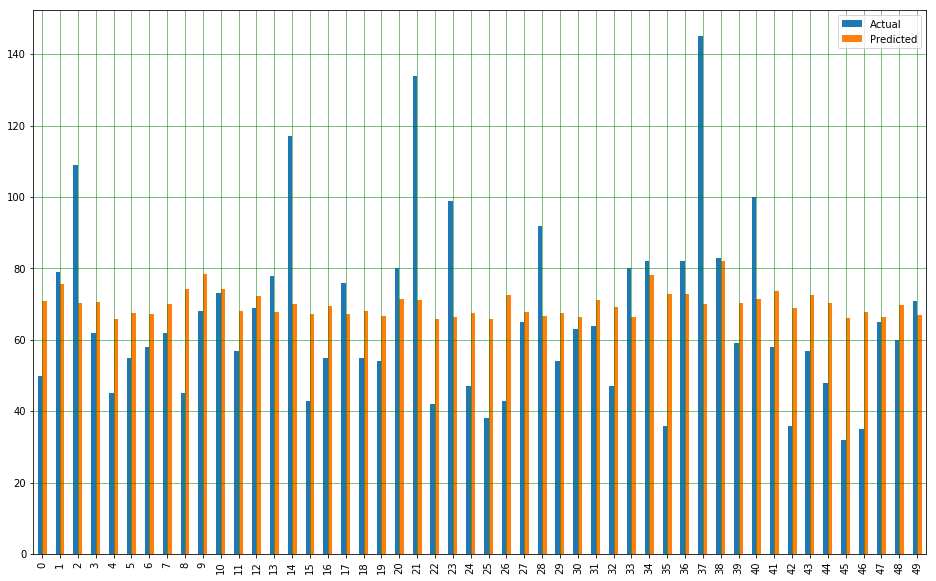

In [99]:
pred_other_Fault_linear = lr.predict(df_other_test_rain)
other_actual_pred_linear= pd.DataFrame({'Actual': df_other_test_fault.flatten(), 'Predicted': pred_other_Fault_linear.flatten()})
bar_plot_df = other_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

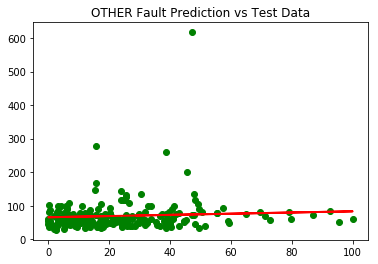

In [100]:
plt.scatter(df_other_test_rain, df_other_test_fault,  color='green')
plt.plot(df_other_test_rain, pred_other_Fault_linear, color='red', linewidth=2)
plt.title('OTHER Fault Prediction vs Test Data') 
plt.show()

In [101]:
rmspe_other = (np.sqrt(np.mean(np.square((df_other_test_fault - pred_other_Fault_linear) / df_other_test_fault)))) * 100
print('Root Mean Squared Error Percentage for Other Faults: ', rmspe_other,'%')

Root Mean Squared Error Percentage for Other Faults:  44.75069998555371 %
